In [1]:
from statsmodels.distributions.empirical_distribution import ECDF


C:\Users\acer\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pylab as pl
import xlrd

import math
import os
import re
import copy
# from numba import njit
# from numba import prange
import plotly

plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go

In [3]:
def average_val_np(array_1, nodes=13):
    """ Построение осредненных распределений """
    b = np.zeros((nodes))
    for i in range(0, nodes):
        b[i] = np.median(np.array_split(array_1, nodes)[i])

    return b

In [4]:
def average_in_list(list):
    # print(list)
    summ = 0
    for i in list:
        summ += i
    return summ / len(list)

In [5]:
def read_data_txt_np(name_of_file, example_dir):
    data_flag = 0
    content = os.listdir(example_dir)
    if os.path.isfile(os.path.join(example_dir, name_of_file)):
        if name_of_file in content:
            file = os.path.join(example_dir, name_of_file)
            if file.endswith('.txt'):
                # data = np.loadtxt(file, dtype='double', skiprows=56) #thermal
                data = np.loadtxt(file, dtype='double', skiprows=44) #isothermal
                data_flag = 1
            else:
                print(f'{file} doesnt ends with .txt')
        else: 
            print(f"No file {name_of_file} in such dir")
    else:
        print(f"No such file {name_of_file}")
        return -1
    return data 

In [6]:
def files_list(list_one, dir_):
    list_files = []
    for i in range(0, len(list_one)):
        file = read_data_txt_np(list_one[i], dir_)
        list_files.append(file)

    return list_files

In [7]:
#@njit(parallel=True)
def preprocessing_res_np(file):
    """
    Создание np.array по репорту
    """
    x_1 = (file[::, 1]) * 10 ** 3
    y_1 = (file[::, 2]) * 10 ** 3

    eps_11_name = file[::, 11]
    eps_22_name = file[::, 12]
    eps_33_name = file[::, 13]
    eps_12_name = file[::, 14]

    stress_11_name = (file[::, 3]) / 10 ** 6
    stress_22_name = (file[::, 4]) / 10 ** 6
    stress_33_name = (file[::, 5]) / 10 ** 6
    stress_12_name = (file[::, 6]) / 10 ** 6

    #nt11_name = (file[::,15])
    #temp_name = (file[::,16])

    index = 0

    x_1_ = np.zeros((1, 1))
    y_1_ = np.zeros((1, 1))
    Strain = np.zeros((1, 5))
    Stress = np.zeros((1, 5))
    #NT11 = np.zeros((1, 1))
    #TEMP = np.zeros((1, 1))
    #ind_ = np.zeros((1,1))
    for j in range(0, np.shape(y_1)[0]):
        if y_1[j] >= 0.25 * (np.max(y_1) - np.min(y_1)) and y_1[j] <= 0.75 * (np.max(y_1) - np.min(y_1)):
            x_1_[index] = x_1[j]
            y_1_[index] = y_1[j]
            #ind_[index] = j

            Stress[index, 0] = stress_11_name[j]
            Stress[index, 1] = stress_22_name[j]
            Stress[index, 2] = stress_33_name[j]
            Stress[index, 3] = stress_12_name[j]
            Stress[index, 4] = (1 / (np.sqrt(2))) * np.sqrt(
                (stress_11_name[j] - stress_22_name[j]) ** 2 + (stress_22_name[j] - stress_33_name[j]) ** 2 + (
                        stress_33_name[j] - stress_11_name[j]) ** 2 + 6 * (stress_12_name[j] ** 2))

            Strain[index, 0] = eps_11_name[j]
            Strain[index, 1] = eps_22_name[j]
            Strain[index, 2] = eps_33_name[j]
            Strain[index, 3] = eps_12_name[j]
            Strain[index, 4] = (1 / (np.sqrt(2))) * np.sqrt(
                (eps_11_name[j] - eps_22_name[j]) ** 2 + (eps_22_name[j] - eps_33_name[j]) ** 2 + (
                        eps_33_name[j] - eps_11_name[j]) ** 2 + 6 * (eps_12_name[j] ** 2))

            #NT11[index]=nt11_name[j]
            #TEMP[index]=temp_name[j]

            x_1_ = np.concatenate((x_1_, np.zeros((1, 1))))
            y_1_ = np.concatenate((y_1_, np.zeros((1, 1))))
            Stress = np.concatenate((Stress, np.zeros((1, 5))))
            Strain = np.concatenate((Strain, np.zeros((1, 5))))
            #NT11 = np.concatenate((NT11,np.zeros((1,1))))
            #TEMP = np.concatenate((TEMP,np.zeros((1,1))))
            index = index + 1

    x_1_ = np.delete(x_1_, -1)
    y_1_ = np.delete(y_1_, -1)
    Stress = np.delete(Stress, -1, axis=0)
    Strain = np.delete(Strain, -1, axis=0)

    x_1_, characteristics = sorter(x_1_, [y_1_, Stress, Strain])
    y_1_, Stress, Strain = characteristics[0], characteristics[1], characteristics[2]

    return x_1_, y_1_, Stress, Strain  #, NT11, TEMP #ind_

In [8]:
def r(job_name):
    # found = re.search('red_(.+?)_', job_name).group(1)
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == 'red':
            found = splitted_job[i+1]
    reduct = float(found) / 10000
    return reduct

def c(job_name):
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == 'cal':
            found = splitted_job[i+1]
    cali = float(found) / 100
    return cali


def f(job_name):
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == 'fric':
            found = splitted_job[i+1][1:]
    fr = float(found) / 1000
    return fr

def v(job_name):
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == 'vel':
            found = splitted_job[i+1]
    velo = int(found)
    return velo

def h(job_name):
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == '2a':
            found = splitted_job[i+1]
    ha = int(found) / 2
    return ha


In [9]:
def tuple_to_df(preproc_data):
    x = preproc_data[0]
    y = preproc_data[1]
    stresses = preproc_data[2]
    strains = preproc_data[3]
    new_column_names = ['x', 'y', 
        'stress_11', 'stress_22', 'stress_33', 'stress_12', 'stress_int',
        'eps_11', 'eps_22', 'eps_33', 'eps_12', 'eps_int'] 
    first_df = pd.DataFrame(np.array([x, y, 
                            stresses[:, 0], stresses[:, 1],
                            stresses[:, 2], stresses[:, 3], stresses[:, 4],
                            strains[:, 0], strains[:, 1], strains[:, 2],
                            strains[:, 3], strains[:, 4]]).T,
                            columns = new_column_names) 
    # first_df.columns = new_column_names

    return first_df

In [10]:
def sorter(xx, heap_of_stresses):
    """
    Сортирует по возрастанию узлы по значению расстояния от оси проволоки и
        перегруппировывает значения в остальных массивах в соответствии с новыми
        значениями индексов, но больше не удаляет точку (0,0)
    :param xx: значения координат х
    :param heap_of_stresses: список характеристик
    :return: x_sorted, heap_of_stresses_sorted
    """

    heap_of_stresses_sorted = heap_of_stresses[:]
    ai = np.argsort(xx, axis=0)
    x_sorted = np.take_along_axis(xx, ai, axis=0)
    ai = ai.flatten()
    # delete_idx = np.where(np.isclose(x_sorted, 0))[0][0]
    # x_sorted = np.delete(x_sorted, delete_idx)

    for idx, i in enumerate(heap_of_stresses):
        ai_i = np.copy(ai)
        if i.ndim > 1:    # alternatively use np.tile instead
            for j in range(i.shape[1]-1):
                ai_i = np.vstack((ai_i, ai))
            ai_i = ai_i.T
        heap_of_stresses_sorted[idx] = np.take_along_axis(i, ai_i, axis=0)
        # heap_of_stresses_sorted[idx] = np.delete(heap_of_stresses_sorted[idx], delete_idx)

    return x_sorted, heap_of_stresses_sorted

In [11]:
def get_param(cur_job_name, vel20List, all20Arrays):
    int_res_stress_idx = vel20List.index(cur_job_name)
    
    int_res_stress = average_val_np(all20Arrays[int_res_stress_idx][2][::, 4], 20)
    
    red = r(cur_job_name)
    cal = c(cur_job_name)
    ha = h(cur_job_name)
    vel = v(cur_job_name)
    fric = f(cur_job_name)

    return [red, cal, ha, vel, fric, int_res_stress]

In [12]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join


# heatmap_pth = '/content/drive/MyDrive/corr_heatmaps'
# if os.path.exists(heatmap_pth) == False:
#   os.mkdir(heatmap_pth)

path_import = r'content\allReports\\'
path_import = '/content/allReports'
path_import = '/content/drive/MyDrive/allReports_reloaded'
path_import = '/content/drive/MyDrive/720'
path_import = r'C:\Users\acer\Desktop\reports_20_30'

rep_list = [fil[:-4] for fil in listdir(path_import) 
            if isfile(join(path_import, fil)) and fil.endswith('.txt')]

In [13]:
vel20List = [fil for fil in rep_list if 'vel_20' in fil and '(' not in fil] 

In [14]:
vel20ListFiles = []
for fi in vel20List:
    vel20ListFiles.append(fi + '.txt')
la = files_list(vel20ListFiles, path_import)
all20Arrays = []
for fl in la:
    all20Arrays.append(preprocessing_res_np(fl))
    print('.', end='')

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [15]:
def split_array(array_1, nodes=20):
    """ Разбиение массива на подмассивы по столбцам """
    b = []
    for i in range(0, nodes):
        b.append(np.sort(np.array_split(array_1, nodes)[i]))

    return b

In [18]:
def generate_number_with_given_set(array, size=20):
    
    ecdf = ECDF(array)
    ecdf_x, ecdf_y = ecdf.x[1:], ecdf.y[1:]
    
    inv_ecdf = np.interp(np.random.rand(size), ecdf_y, ecdf_x)
    return inv_ecdf

In [19]:
generated_characteristics = np.array([generate_number_with_given_set(split_array(train)[i]) for i in range(len(split_array(train)))])

In [20]:
generated_characteristics

array([[119.74708907, 118.36514196, 123.48682442, 124.2159221 ,
        123.50387299, 122.40336599, 117.1108637 , 125.1817273 ,
        118.61561333, 120.36627223, 120.33433328, 124.27159888,
        121.91254709, 120.0776929 , 120.25883564, 117.76151697,
        118.81420738, 120.3282273 , 123.3465117 , 120.11324634],
       [123.02324445, 121.77089268, 123.91988729, 119.12181501,
        124.167081  , 121.91552422, 123.95852297, 122.00272002,
        123.70985578, 125.74915602, 121.94405719, 124.59291191,
        119.26282614, 123.21073957, 120.33654777, 124.48781684,
        122.34073276, 121.84012132, 123.69678367, 121.94145066],
       [122.62863308, 122.2527141 , 118.5410473 , 121.06609569,
        108.36716195, 119.01767852, 121.40177882, 121.27410984,
        122.5179477 , 122.12388014, 121.64922263, 121.32238167,
        121.75730279, 121.66589998, 122.66010751, 121.06583565,
        121.31682968, 119.63430978, 121.81748864, 121.58281988],
       [117.64673695, 118.0511484 , 1

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:3

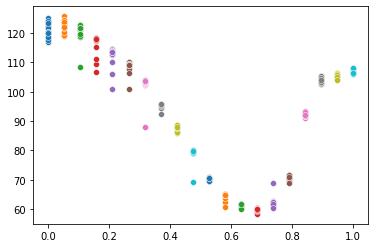

In [35]:
for i in range(len(generated_characteristics)):
    sns.scatterplot(np.ones(len(generated_characteristics[i]))*i/19, generated_characteristics[i])